### Calibrating the COSMOS source cuts (25.2 mag limit) and weights to match the CLASH background source distribution

In [1]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt
import pandas as pd

from copy import copy
from os.path import expanduser
from scipy.stats import binned_statistic_2d

from wlenet import config
from wlenet.cluster.cluster_lensing import ClusterLensing
from wlenet.cluster.cluster_survey import ClusterSurvey
from wlenet.simulation.galsim_simulation import GalsimSimulation
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.figures import show_stamps

Using TensorFlow backend.


In [2]:
weight_indices_name = 'cosmos_to_clash_weights'
cosmos_sim_name = 'clash_003_test'
noise_kernel_name = 'clash'
noise_kernel_factor = 1.0
delta_m = 0.7
post_sim = {"intensity_cutoff": 0.012, "flux_cut_min": -np.inf, "flux_factor": None}
save_weights = False
save_post_sim = False
save_figures = False
figsize_factor = 1.0

Obtain a COSMOS catalog from a GalsimSimulation

In [3]:
cosmos_sim_path = config['simulation_configs_path'] + '/' + cosmos_sim_name + '_sim.json'

In [4]:
cosmos_zeropoint_path = expanduser(config['calibration_path'] + '/cosmos_zeropoint.npy')
cosmos_zeropoint = np.load(cosmos_zeropoint_path).item()
clash_zeropoint_path = expanduser(config['calibration_path'] + '/clash_zeropoint.npy')
clash_zeropoint = np.load(clash_zeropoint_path).item()

In [5]:
gss = GalsimSimulation(cosmos_sim_path)
gss.args.weight_index_path = ''
gss.args.preload = 0
gss.init()

Loading the RealGalaxyCatalog real_galaxy_catalog_25.2.fits (preload=0)
Using valid-index file ~/datasets/wlenet/calibration/cosmos_valid_indices.npy
Splitting catalog samples to train and test samples using the static seed
Using the static seed for train/test split
Total catalog galaxies: 87798
Valid catalog galaxies: 87750
Train catalog galaxies: 65756
Test catalog galaxies : 21994
Using the dynamic seed for the rest of this simulation


Load the CLASH survey and use the computed half-light-radii, photometric catalog redshifts

In [6]:
%%capture
cluster_template = ClusterLensing(cut_params={'apply_extra_cut': True})
survey = ClusterSurvey(cluster_template)
survey.process_survey()
survey.remove_tmp_files()

Compute a 2-d histogram of the COSMOS and CLASH galaxies in the radius-redshift plane -

In [7]:
edges_m = np.linspace(18.5, 28, 60)
edges_r = np.linspace(np.log10(0.9), np.log10(25), 51)

r_pixel_scale = 0.065
cosmos_pixel_scale = 0.03
cosmos_rescale = (r_pixel_scale/cosmos_pixel_scale)/4
reweight_factor_min = 0
reweight_factor_max = 10.0
p_cosmos_min = 3e-6
print('cosmos_rescale =', cosmos_rescale)

cosmos_rescale = 0.5416666666666667


In [8]:
cosmos_r = np.log10(gss.fit_catalog['flux_radius'][gss.valid_indices] * ((cosmos_pixel_scale / r_pixel_scale)) * cosmos_rescale)
cosmos_m = gss.fit_catalog['mag_auto'][gss.valid_indices] - 2.5*ma.log10(cosmos_rescale**2)
clash_r = np.log10(survey.cut['flux_radius'])
clash_m = survey.cut['mag_auto'] + clash_zeropoint
cosmos_m = cosmos_m + delta_m 

In [9]:
flux_factor = 10**((delta_m - clash_zeropoint + cosmos_zeropoint)/(-2.5))
post_sim['flux_factor'] = flux_factor
print('flux_factor = ', flux_factor)

flux_factor =  0.32032025987044893


In [10]:
if save_post_sim:
    post_sim_path = expanduser(config['calibration_path'] + '/cosmos_to_clash_post_sim.npy')
    np.save(post_sim_path, post_sim)

In [11]:
n_clash = np.histogram2d(clash_m, clash_r, [edges_m, edges_r], normed=False)[0]
n_cosmos = np.histogram2d(cosmos_m, cosmos_r, [edges_m, edges_r], normed=False)[0]
p_clash = n_clash / np.sum(n_clash)
p_cosmos = n_cosmos / np.sum(n_cosmos)

In [12]:
from scipy.signal import fftconvolve
from wlenet.reduction.stamps import stamp_centered_grid

x = y = np.linspace(-5, 5, 11) / 1
xx, yy = np.meshgrid(x, y)
kernel = np.exp(-0.5*(xx**2 + yy**2))
kernel = kernel / np.sum(kernel)

p_clash = fftconvolve(p_clash, kernel, 'same')
p_cosmos = fftconvolve(p_cosmos, kernel, 'same')

In [13]:
cosmos_to_clash_factor = np.minimum(reweight_factor_max, np.maximum(reweight_factor_min, p_clash / p_cosmos))
cosmos_to_clash_factor[p_cosmos < p_cosmos_min] = np.nan

p_cosmos_corrected = p_cosmos*cosmos_to_clash_factor
p_cosmos_corrected /= np.nansum(p_cosmos_corrected)

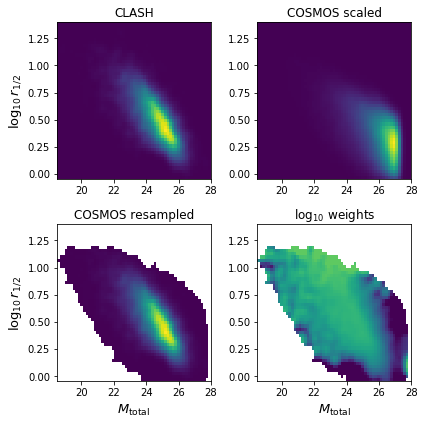

In [14]:
plt.rcParams["figure.figsize"] = np.array([6, 6])*figsize_factor
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

img1 = ax1.imshow((p_clash.T), origin='lower', extent=[edges_m[0], edges_m[-1], edges_r[0], edges_r[-1]], aspect='auto')
img2 = ax2.imshow((p_cosmos.T), origin='lower', extent=[edges_m[0], edges_m[-1], edges_r[0], edges_r[-1]], aspect='auto')
img3 = ax3.imshow((p_cosmos_corrected.T), origin='lower', extent=[edges_m[0], edges_m[-1], edges_r[0], edges_r[-1]], aspect='auto')
img4 = ax4.imshow(np.log10(cosmos_to_clash_factor.T), origin='lower', extent=[edges_m[0], edges_m[-1], edges_r[0], edges_r[-1]], aspect='auto', clim=[-2,2])

ax1.set_title('CLASH')
ax1.set_ylabel(r'$\log_{10}\,r_{1/2}$', fontsize=13)
#ax1.set_xlabel(r'$M_\mathrm{total}$', fontsize=13)

ax2.set_title('COSMOS scaled')
#ax2.set_ylabel(r'$\log_{10}\,r_{1/2}$', fontsize=13)
#ax2.set_xlabel(r'$M_\mathrm{total}$', fontsize=13)

ax3.set_title('COSMOS resampled')
ax3.set_ylabel(r'$\log_{10}\,r_{1/2}$', fontsize=13)
ax3.set_xlabel(r'$M_\mathrm{total}$', fontsize=13)

ax4.set_title('$\log_{10}$ weights')
#ax4.set_ylabel(r'$\log_{10}\,r_{1/2}$', fontsize=13)
ax4.set_xlabel(r'$M_\mathrm{total}$', fontsize=13)

plt.tight_layout()

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/cosmos_to_clash_weights_2d.pdf')
    plt.savefig(fig_path)

In [15]:
dummy = np.ones(cosmos_m.shape)
stats = binned_statistic_2d(cosmos_m, cosmos_r, dummy, bins=[edges_m, edges_r])
m_ind, r_ind = np.unravel_index(stats.binnumber, (len(stats.x_edge) + 1, len(stats.y_edge) + 1))
out_of_bounds = (m_ind == 0) | (r_ind == 0) | (m_ind == len(stats.x_edge)) | (r_ind == len(stats.y_edge))

m_ind = np.minimum(np.maximum(0, m_ind - 1), len(edges_m)-2)
r_ind = np.minimum(np.maximum(0, r_ind - 1), len(edges_r)-2)

weights = cosmos_to_clash_factor.flatten()[r_ind + m_ind * (len(edges_r)-1)]
weights[out_of_bounds] = 0
weights[np.isnan(weights)] = 0
weights /= np.sum(weights)

Perform some sanity checks: check how well the reweighted 1-d radius and redshift distributions match

In [16]:
print([np.nanmean(clash_m), np.mean(cosmos_m), np.sum(cosmos_m*weights)])
print([np.mean(clash_r), np.mean(cosmos_r), np.sum(cosmos_r*weights)])

[24.51104270798304, 25.9130817007757, 24.535064424402396]
[0.5159394009057436, 0.352827863512366, 0.5110780467306285]


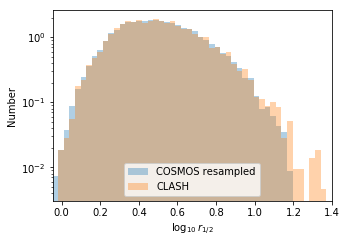

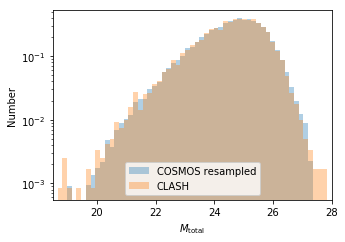

In [17]:
hist_clash_r = np.histogram(clash_r, bins=edges_r, normed=True)[0]
hist_cosmos_r = np.histogram(cosmos_r, bins=edges_r, normed=True)[0]
hist_cosmos_r_reweighted = np.histogram(cosmos_r, bins=edges_r, weights=weights, normed=True)[0]

clash_m_inds = ~np.isnan(clash_m)
hist_clash_m = np.histogram(clash_m[clash_m_inds], bins=edges_m, normed=True)[0]
hist_cosmos_m = np.histogram(cosmos_m, bins=edges_m, normed=True)[0]
hist_cosmos_m_reweighted = np.histogram(cosmos_m, bins=edges_m, weights=weights, normed=True)[0]

plt.figure(figsize=np.array([5, 3.5])*figsize_factor)
plt.bar(edges_r[:-1], hist_cosmos_r_reweighted, align='edge', width=edges_r[1]-edges_r[0], alpha=0.35, label='COSMOS resampled', log=True)
plt.bar(edges_r[:-1], hist_clash_r, align='edge', width=edges_r[1]-edges_r[0], alpha=0.35, label='CLASH', log=True)
plt.xlim([edges_r[0], edges_r[-1]])
plt.xlabel('$\log_{10}\,r_{1/2}$')
plt.ylabel('Number')
plt.legend(loc="lower center")

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/cosmos_to_clash_weights_flux_radius.pdf')
    plt.savefig(fig_path)
    
plt.figure(figsize=np.array([5, 3.5])*figsize_factor)
plt.bar(edges_m[:-1], hist_cosmos_m_reweighted, align='edge', width=edges_m[1]-edges_m[0], alpha=0.35, label='COSMOS resampled', log=True)
plt.bar(edges_m[:-1], hist_clash_m, align='edge', width=edges_m[1]-edges_m[0], alpha=0.35, label='CLASH', log=True)
plt.xlim([edges_m[0], edges_m[-1]])
plt.xlabel('$M_\mathrm{total}$')
plt.ylabel('Number')
plt.legend(loc="lower center")

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/cosmos_to_clash_weights_magnitude.pdf')
    plt.savefig(fig_path)

In [18]:
eff_sample_num = np.sum(weights / np.max(weights))
print('eff_sample_num =', eff_sample_num)
print('eff_sample_num*0.25 =', eff_sample_num*0.25)

eff_sample_num = 8540.36485343204
eff_sample_num*0.25 = 2135.09121335801


Save the resulting weight table

In [19]:
if save_weights:
    weights_full = np.ones((gss.rgc.nobjects,))
    weights_full[gss.valid_indices] = weights.copy()
    weights_full /= np.sum(weights_full)
    weights_path = expanduser(config['calibration_path'] + '/cosmos_to_clash_weights.npy')
    np.save(weights_path, weights_full)

In [20]:
noise_kernel_path = config['calibration_path'] + '/' + noise_kernel_name + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) * noise_kernel_factor

In [21]:
gss = GalsimSimulation(cosmos_sim_path)
gss.args.test_train = 'test'
gss.args.preload = 0
gss.args.size_rescale = cosmos_rescale
gss.args.num_gals = 1000
gss.init()

Loading the RealGalaxyCatalog real_galaxy_catalog_25.2.fits (preload=0)
Using valid-index file ~/datasets/wlenet/calibration/cosmos_valid_indices.npy
Using weight-index file ~/datasets/wlenet/calibration/cosmos_to_clash_weights.npy
Splitting catalog samples to train and test samples using the static seed
Using the static seed for train/test split
Total catalog galaxies: 87798
Valid catalog galaxies: 87750
Train catalog galaxies: 65756
Test catalog galaxies : 21994
Using the dynamic seed for the rest of this simulation


In [22]:
cosmos_stamps, cosmos_shears, cosmos_metadata = gss.render_stamps()
cosmos_stamps = cosmos_stamps[:, :, :, np.newaxis]


[==================================================] 100.0% rendered galaxy 1000/1000 [whitening retries 0]



In [23]:
cosmos_stamps_ = cosmos_stamps.copy()
cosmos_stamps_[cosmos_stamps_ < post_sim['intensity_cutoff']] = 0
cosmos_stamps_ = cosmos_stamps_ * post_sim['flux_factor']

In [24]:
seq = CorrelatedNoiseSequence({'x': cosmos_stamps_, 'y': cosmos_shears}, noise_kernel, norm_func=None)
seq_stamps = generate_batches(seq, 1, batch_idx_start=7)[0]

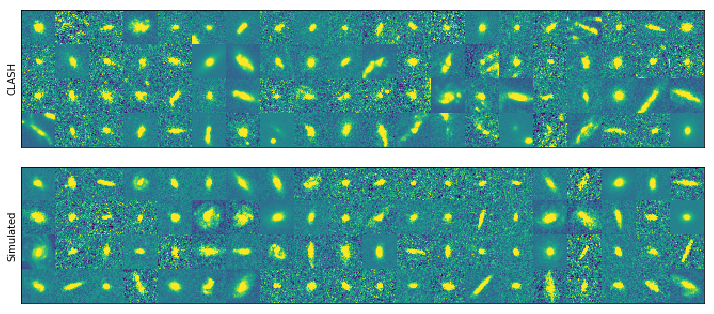

In [25]:
np.random.seed(1234567)
permed_clash_indices = np.random.permutation(len(survey.cut['stamps']))

fig = plt.figure(figsize=np.array([10, 4.5])*figsize_factor)
plt.subplot(2, 1, 1)
show_stamps(survey.cut['stamps'][permed_clash_indices,:,:], num_pages=1, rows=4, cols=20, ylabel='CLASH', no_show=True, figsize=None)
plt.subplot(2, 1, 2)
show_stamps(seq_stamps, num_pages=1, rows=4, cols=20, ylabel='Simulated', no_show=True, figsize=None)
plt.tight_layout()

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/cosmos_to_clash_flux_stamps.pdf')
    plt.savefig(fig_path)